# Sheet 02

In [1]:
#%pylab inline
%pylab

from itertools import permutations
from typing import Callable, Dict, List, Tuple
import warnings

import matplotlib as mpl
from matplotlib.patches import Ellipse
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from scipy.io import loadmat
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.spatial import Voronoi, voronoi_plot_2d

import seaborn as sns

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Assignment 1

In [22]:
def kmeans(X: np.ndarray, k: int, max_iter: int=100,
           print_progress=True, mu=None) -> Tuple[np.ndarray, np.ndarray, float]:
    N, M = X.shape
    X = np.asarray(X)
    if mu is None or np.all(mu == 0):
        indexes = np.random.choice(np.arange(N), size=k, replace=False)
        mu = X[indexes].copy()
        
    r = np.zeros(N, dtype=int)
    last_r = np.zeros_like(r)
    loss = np.inf

    for i in range(max_iter):
        # assign all datapoints to their closest prototype
        dists = cdist(X, mu, metric='sqeuclidean')
        r = np.argpartition(dists, 0, axis=1)[:, 0]

        # re-compute the new positions of the prototypes
        # for this assignment
        loss = 0
        for j in range(k):
            X_assigned = r == j
            # easiest way to handle empty clusters is to
            # just ignore them 
            if X_assigned.any():
                cluster = X[X_assigned, :]
                mu[j] = cluster.mean(axis=0)
                loss += np.linalg.norm(cluster - mu[j])
        
        changes_nr = (last_r != r).sum()
        if print_progress:
            print(f"Iteration: {i}.")
            print(f"Number of changes: {changes_nr}.")
            print(f"Loss: {loss}")
        if changes_nr == 0:
            break
        last_r = r

    print(f"Number of iterations: {i + 1}. Loss: {loss}")

    return mu, r, loss

## Assignment 2

In [3]:
def loss(X, r):
    k = r.max() + 1
    loss = 0
    for i in range(k):
        cluster = X[r == i].copy()
        if len(cluster):
            mu = cluster.mean(axis=0)
            loss += np.linalg.norm(cluster - mu)
    return loss


def kmeans_agglo(X, r) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    N, M = X.shape
    k = r.max() + 1
    R = np.zeros((k - 1, N), dtype=int)
    kmloss = np.zeros(k)
    mergeidx = np.zeros((k - 1, 2), dtype=int)

    kmloss[0] = loss(X, r)
    for i in range(k - 1):
        old_r = r.copy()
        R[i] = old_r
        min_loss = np.inf
        for ri, rj in permutations(np.unique(old_r), 2):
            new_r = old_r.copy()
            new_r[new_r == ri] = rj
            new_loss = loss(X, new_r)
            if new_loss < min_loss:
                mergeidx[i, :] = ri, rj
                min_loss = new_loss
                r = new_r
        kmloss[i + 1] = min_loss
    return R, kmloss, mergeidx

## Assignment 3

In [4]:
def agglo_dendro(kmloss: np.ndarray, mergeidx: np.ndarray, ax=None) -> None:
    N, _ = mergeidx.shape
    Z = np.ones((N, 4))
    Z[:, :2] = mergeidx
    Z[:, 2] = kmloss[1:]
    max_r = mergeidx.max()
    for i, (_, c2) in enumerate(Z[:, :2]):
        max_r += 1
        offset = np.zeros(i+1, dtype=bool)
        mask = np.hstack((offset, Z[i+1:, 0]==c2))
        Z[mask, 0] = max_r
        mask = np.hstack((offset, Z[i+1:, 1]==c2))
        Z[mask, 1] = max_r

    close_fig = False
    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        close_fig = True
    dendrogram(Z, ax=ax)
    if close_fig:
        plt.show()
        plt.close()

## Assingment 4

In [5]:
def norm_pdf(X: np.ndarray, mu: np.ndarray, C: np.ndarray, tol: float=1e-5, modify_C: bool=False) -> np.ndarray:
    _, M = X.shape
    try:
        det_C = np.linalg.det(C)
        i = 1
        while det_C < tol:
            if modify_C:
                C += np.eye(M) * tol * i
            else:
                C = C + np.eye(M) * tol * i
            det_C = np.linalg.det(C)
            i += 1
        X = X.T
        C = C.T
        mu = mu.reshape(M, 1)
        b = X - mu
        c, *_ = np.linalg.lstsq(C, b)
        denominator = (2*np.pi)**(M/2) * det_C**0.5
        nominator = np.diag(b.T @ c)
        nominator = np.exp(-nominator/2)
        return nominator/denominator
    except:
        print(C)
        print(det_C)
        raise

## Assignment 5

In [6]:
def em_gmm(X: np.ndarray, k: int, max_iter: int=100,
           init_kmeans=None, tol: float=1e-5,
           print_progress=True)\
        -> Tuple[np.ndarray, np.ndarray,
                 np.ndarray, float]:
    N, M = X.shape
    pi = np.ones(k)/k
    if init_kmeans is None:
        indexes = np.random.choice(np.arange(N), size=k, replace=False)
        mu = X[indexes].copy()
    else:
        mu = init_kmeans
    sigma = np.zeros((k, M, M)) + np.eye(M)
    loglik = 0
    prev_loglik = 0
    gamma = np.zeros((k, N))
    for i in range(max_iter):
        # E-step
        for centr in range(k):
            gamma[centr] = pi[centr] * norm_pdf(X, mu[centr], sigma[centr], tol=tol, modify_C=True)
        gamma /= gamma.sum(axis=0)
        # M-step
        loglik = 0
        for centr in range(k):
            gamma_centr = gamma[centr, :].reshape(N, 1)
            Nk = gamma_centr.sum()
            pi[centr] = Nk/N
            mu[centr] = (X * gamma_centr).sum(axis=0)/Nk
            mu_centr = mu[centr]
            b = np.sqrt(gamma_centr) * (X - mu_centr)
            sigma[centr] = (b.T @ b)/Nk
            loglik += (gamma_centr * norm_pdf(X, mu_centr, sigma[centr], tol=tol, modify_C=True)).sum()
        loglik = np.log(loglik)
        if print_progress:
            print(f"Iteration: {i}. Log likelihood: {loglik}")
        if np.isclose(loglik, prev_loglik):
            break
        prev_loglik = loglik
    print(f"Number of iterations: {i + 1}. Log likelihood: {loglik}")
    return pi, mu, sigma, loglik

## Assignment 6

In [7]:
def plot_gmm_solution(X: np.ndarray, mu: np.ndarray,
                      sigma: np.ndarray, ax=None) -> None:
    close_fig = False
    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        close_fig = True
    x_min, y_min = X.min(axis=0) - np.ones(2)
    x_max, y_max = X.max(axis=0) + np.ones(2)
    ax.scatter(*X.T)
    ax.scatter(*mu.T, marker='+', c='r')

    for sig, centr in zip(sigma, mu):
        lambda_, v = np.linalg.eig(sig)
        lambda_ = np.sqrt(lambda_)

        ell = Ellipse(xy=(centr[0], centr[1]),
                      width=lambda_[0], height=lambda_[1],
                      angle=np.rad2deg(np.arccos(v[0, 0])))
        ell.set_facecolor('none')
        ell.set_edgecolor('r')
        ell.set_linewidth(1)
        ax.add_artist(ell)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if close_fig:
        plt.show()
        plt.close()


def plot_kmeans(X: np.ndarray, mu: np.ndarray, r: np.ndarray,
               ax=None) -> None:
    close_fig = False
    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        close_fig = True

    x_min, y_min = X.min(axis=0) - np.ones(2)*0.25
    x_max, y_max = X.max(axis=0) + np.ones(2)*0.25

    for x, ri in zip(X, r):
        ax.text(*x, str(ri), alpha=0.75,
                 color=sns.color_palette()[0])
    for i, m in enumerate(mu):
        ax.text(*m, str(i), fontweight='bold',
                 fontsize=15, color='r')

    if mu.shape[0] > 2:
        vor = Voronoi(mu)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', mpl.cbook.MatplotlibDeprecationWarning)
            voronoi_plot_2d(vor, ax=ax, show_points=False, line_colors='r')
    else:
        a, b = mu.mean(axis=0)
        m = -(mu[0, 0] - mu[1, 0])/(mu[0, 1] - mu[1, 1])
        ax.plot([x_min, 2*x_max], [(x_min - a)*m + b, (2*x_max - a)*m + b], '--r', lw=1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if close_fig:
        plt.show()
        plt.close()

## Assignment 7

In [42]:
def plot_clustering(data, axes, k, init_kmeans, mu=None, tol=1e-5):
    print(f"k: {k}")
    km_mu, r, _ = kmeans(data, k, print_progress=False, mu=mu)
    _, kmloss, mergeidx = kmeans_agglo(data, r)
    if init_kmeans:
        gmm_pi, gmm_mu, gmm_sigma, _ = em_gmm(data, k, init_kmeans=km_mu,
                                              print_progress=False, tol=tol)
    else:
        gmm_pi, gmm_mu, gmm_sigma, _ = em_gmm(data, k, print_progress=False, tol=tol)

    if len(axes) == 3:
        ax1, ax2, ax3 = axes
        ax1.set_ylabel(fr"$k={k}$")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_yticks([])
        ax2.grid()
        ax3.set_xticks([])
        ax3.set_yticks([])
        agglo_dendro(kmloss, mergeidx, ax=ax2)
    else:
        ax1, ax3 = axes
        ax1.set_ylabel(fr"$k={k}$")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax3.set_xticks([])
        ax3.set_yticks([])
    plot_kmeans(data, km_mu, r, ax=ax1)
    plot_gmm_solution(data, gmm_mu, gmm_sigma, ax=ax3)
    return km_mu

k: 2
Number of iterations: 2. Loss: 30.550950122763624
Number of iterations: 11. Log likelihood: 10.134233580363368
k: 3
Number of iterations: 3. Loss: 21.27799635460551
Number of iterations: 21. Log likelihood: 10.94549794587438
k: 4
Number of iterations: 11. Loss: 20.90863461793043
Number of iterations: 37. Log likelihood: 11.044210514959893
k: 5
Number of iterations: 8. Loss: 18.000075173308076
Number of iterations: 37. Log likelihood: 11.3367530957585
k: 6
Number of iterations: 10. Loss: 17.701583232419125
Number of iterations: 25. Log likelihood: 11.562577487229596
k: 7
Number of iterations: 9. Loss: 18.235228529025004
Number of iterations: 26. Log likelihood: 11.589842566911772


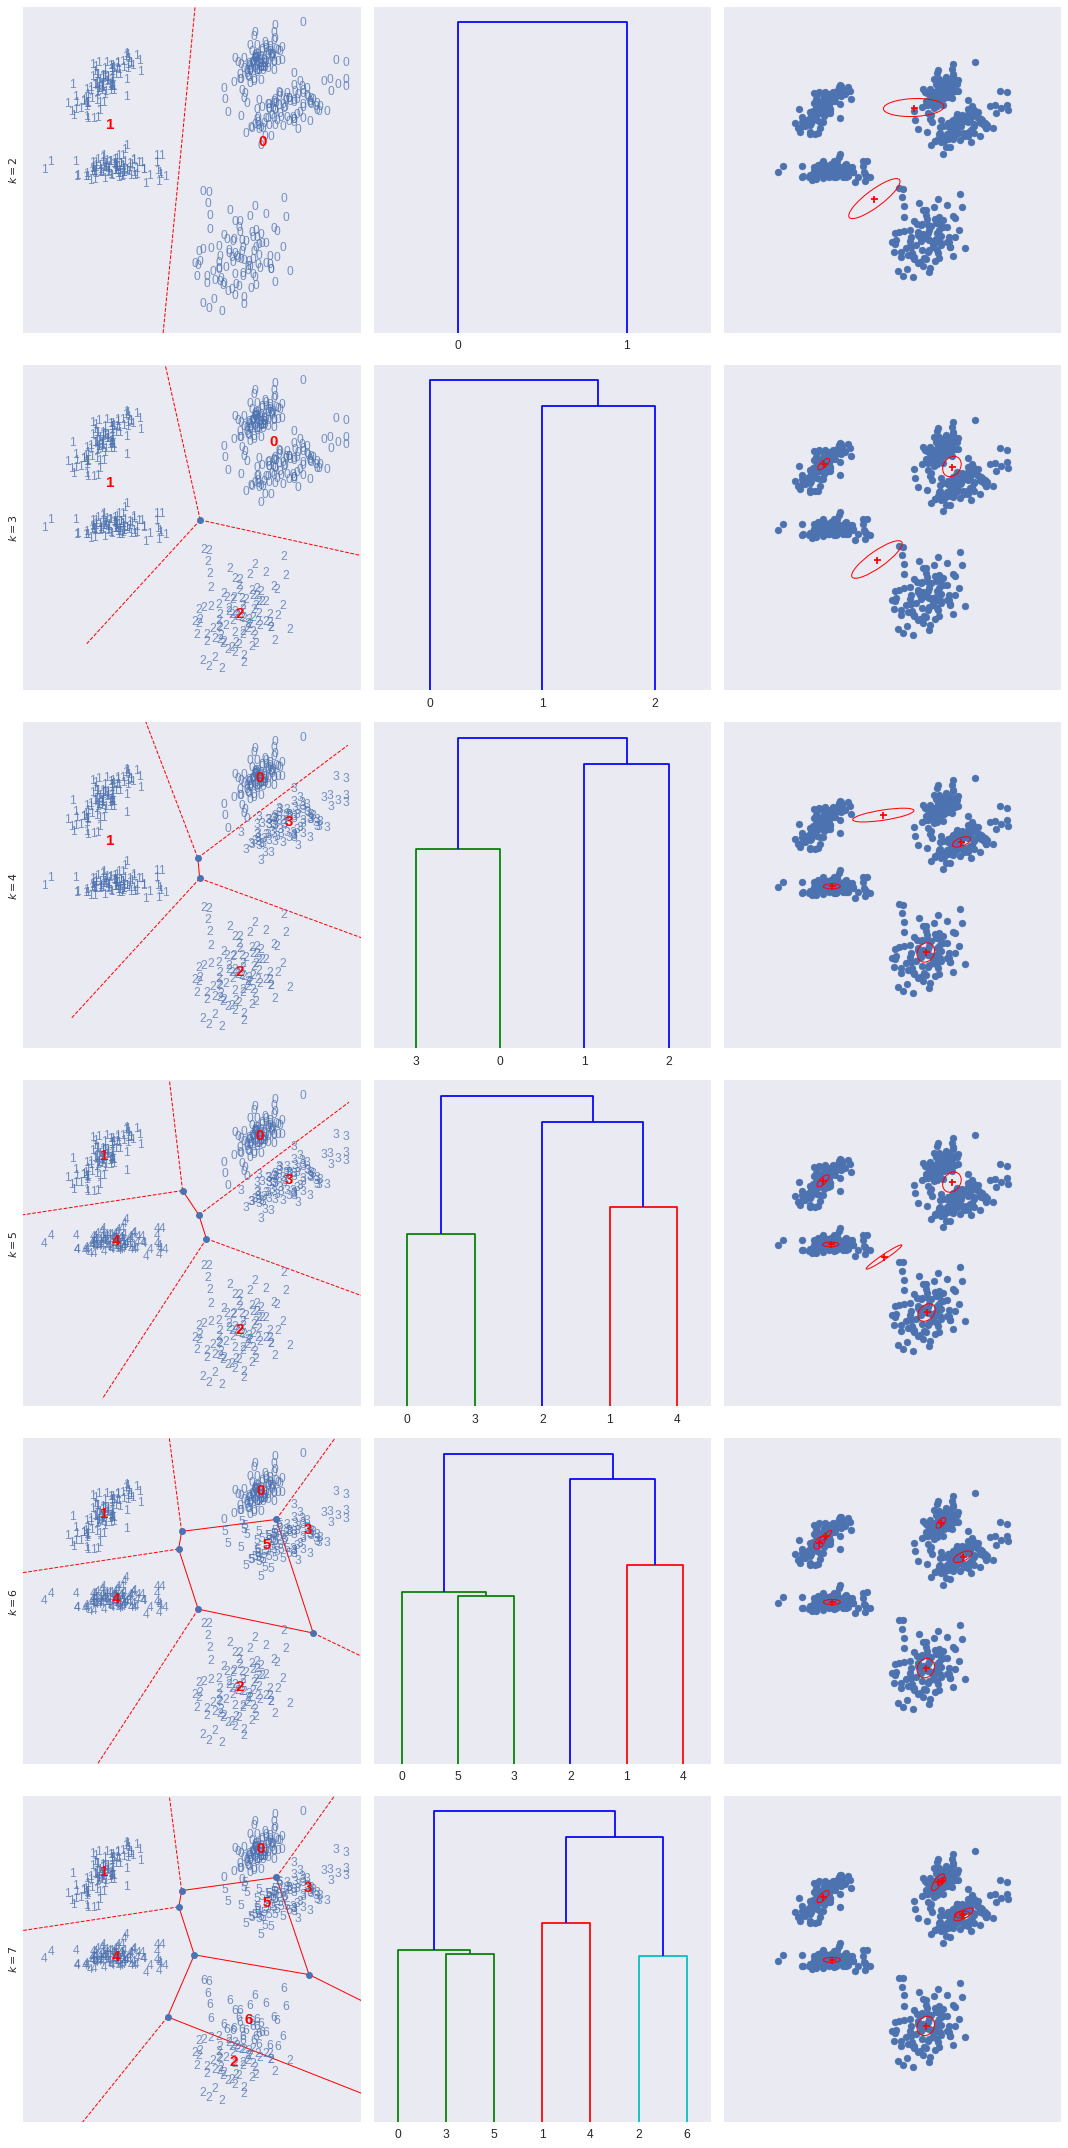

In [27]:
gaussians5 = np.load('./5_gaussians.npy').T
plt.figure()
_, axes = plt.subplots(6, 3, figsize=(15, 5*6))
mu = np.zeros((7, 2))
for k, ax in enumerate(axes, 2):
    mu[:k] = plot_clustering(gaussians5, ax, k, init_kmeans=False, mu=mu[:k])
plt.tight_layout()

k: 2
Number of iterations: 5. Loss: 30.550950122763624
Number of iterations: 5. Log likelihood: 10.402695845072195
k: 3
Number of iterations: 3. Loss: 21.27799635460551
Number of iterations: 5. Log likelihood: 10.77969850372502
k: 4
Number of iterations: 11. Loss: 20.90863461793043
Number of iterations: 25. Log likelihood: 11.144076815673474
k: 5
Number of iterations: 8. Loss: 18.000075173308076
Number of iterations: 25. Log likelihood: 11.550075446190167
k: 6
Number of iterations: 10. Loss: 17.701583232419125
Number of iterations: 56. Log likelihood: 11.58810880485719
k: 7
Number of iterations: 9. Loss: 17.753165114686382
Number of iterations: 40. Log likelihood: 11.587558546072948


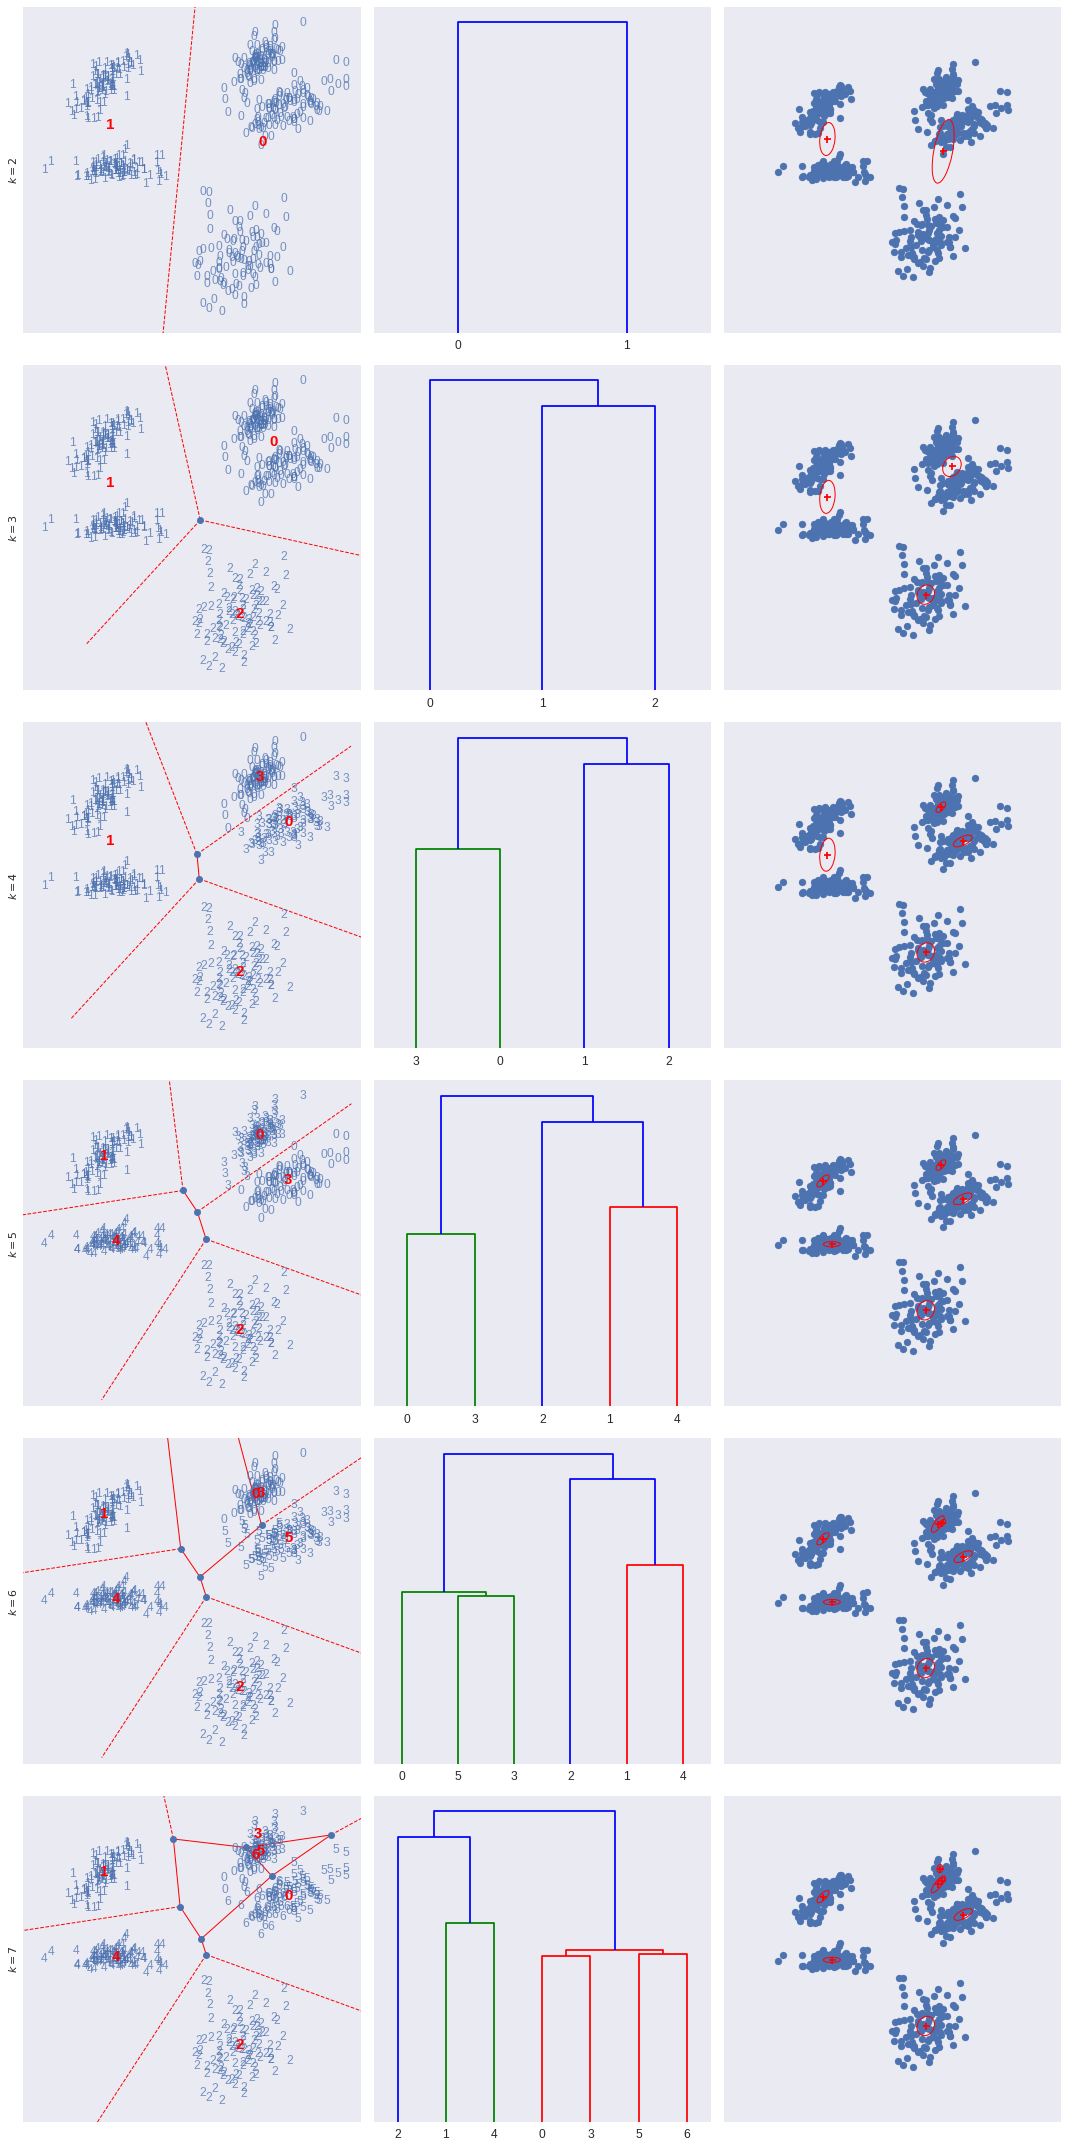

In [29]:
gaussians5 = np.load('./5_gaussians.npy').T
plt.figure()
_, axes = plt.subplots(6, 3, figsize=(15, 5*6))
mu = np.zeros((7, 2))
for k, ax in enumerate(axes, 2):
    mu[:k] = plot_clustering(gaussians5, ax, k, init_kmeans=True, mu=mu[:k])
plt.tight_layout()

## Assignment 8

k: 2
Number of iterations: 4. Loss: 16.992627736887044
Number of iterations: 51. Log likelihood: 8.904406471984943
k: 2
Number of iterations: 12. Loss: 16.185400052166447
Number of iterations: 8. Log likelihood: 8.509146900774116
k: 2
Number of iterations: 7. Loss: 16.50193832730284
Number of iterations: 20. Log likelihood: 8.537131313411832
k: 2
Number of iterations: 7. Loss: 16.665469292554896
Number of iterations: 59. Log likelihood: 8.964801384455194
k: 2
Number of iterations: 7. Loss: 16.373113106665492
Number of iterations: 38. Log likelihood: 9.040303312343243


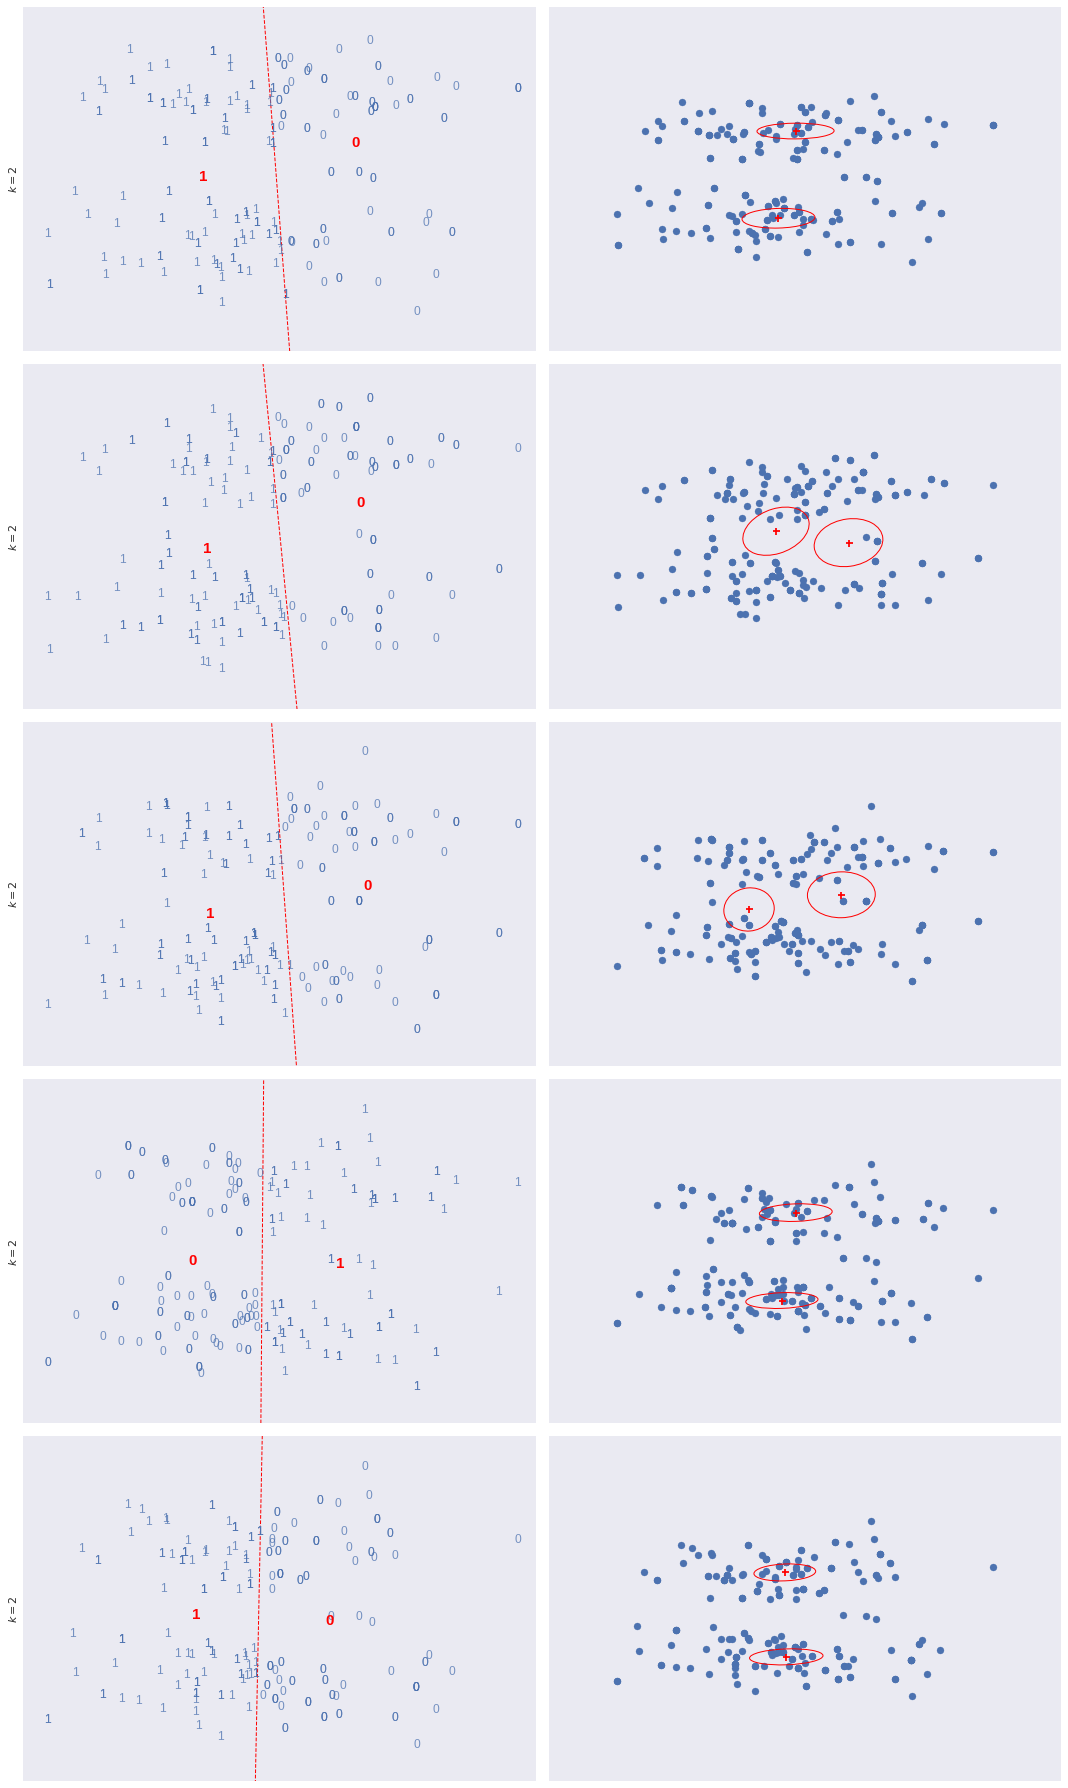

In [44]:
gaussians2 = np.load('./2_gaussians.npy').T
plt.figure()
_, axes = plt.subplots(5, 2, figsize=(15, 5*5))
k = 2
for ax in axes:
    plot_clustering(gaussians2[np.random.randint(len(gaussians2), size=len(gaussians2))],
                    ax, k, init_kmeans=False)
plt.tight_layout()

k: 2
Number of iterations: 10. Loss: 16.864916587762618
Number of iterations: 20. Log likelihood: 8.533912934746498
k: 2
Number of iterations: 9. Loss: 16.864347868901895
Number of iterations: 20. Log likelihood: 8.533892879235726
k: 2
Number of iterations: 9. Loss: 16.864347868901895
Number of iterations: 20. Log likelihood: 8.533892879235726
k: 2
Number of iterations: 6. Loss: 16.864347868901895
Number of iterations: 20. Log likelihood: 8.533892879235726
k: 2
Number of iterations: 9. Loss: 16.864347868901895
Number of iterations: 20. Log likelihood: 8.533892879235726


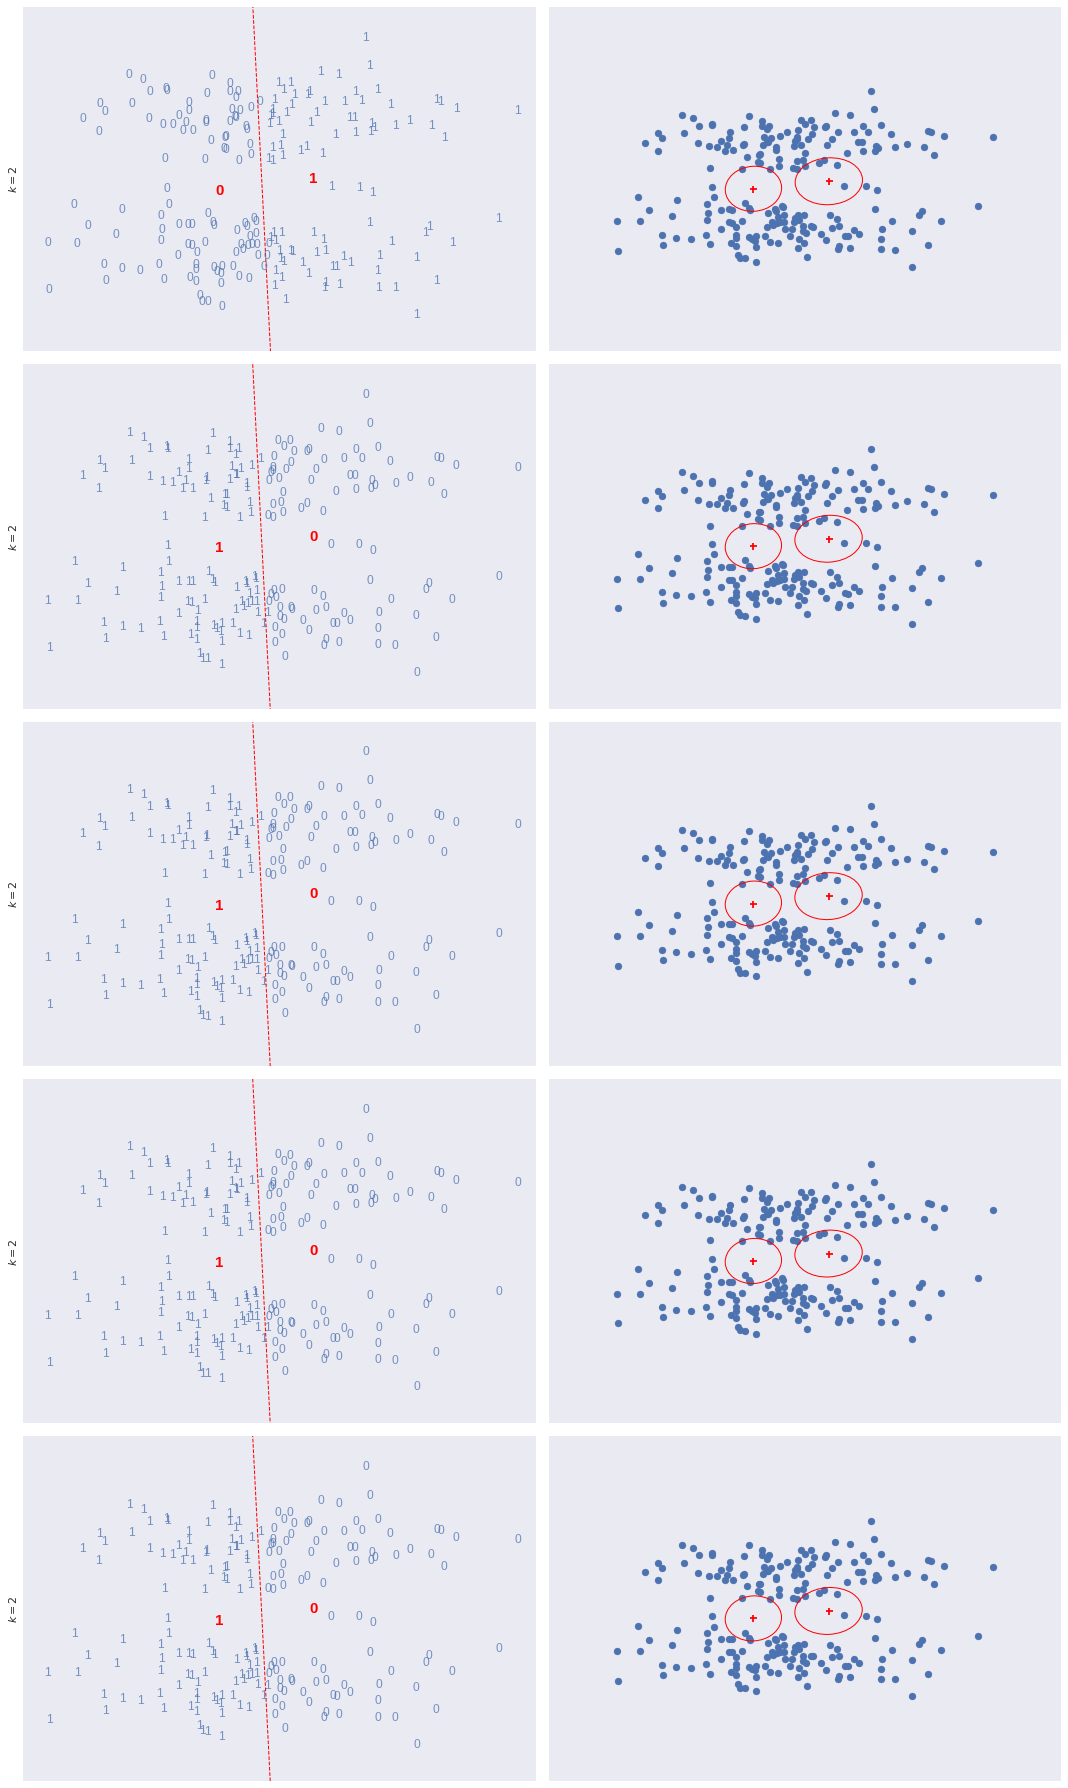

In [43]:
gaussians2 = np.load('./2_gaussians.npy').T
plt.figure()
_, axes = plt.subplots(5, 2, figsize=(15, 5*5))
k = 2
for ax in axes:
    plot_clustering(gaussians2, ax, k, init_kmeans=True)
plt.tight_layout()

## Assignment 9

Number of iterations: 45. Loss: 868.0774172482813
Iteration: 0. Log likelihood: -229.79113778662278
Iteration: 1. Log likelihood: -229.86171802050356
Iteration: 2. Log likelihood: -230.24926621801578
Iteration: 3. Log likelihood: -230.84232721661684
Iteration: 4. Log likelihood: -231.37880659209353
Iteration: 5. Log likelihood: -231.77764096173772
Iteration: 6. Log likelihood: -232.1036821074452
Iteration: 7. Log likelihood: -232.3598050997369
Iteration: 8. Log likelihood: -232.5526837588682
Iteration: 9. Log likelihood: -232.71198894650314
Iteration: 10. Log likelihood: -232.84443022381862
Iteration: 11. Log likelihood: -232.94019727787725
Iteration: 12. Log likelihood: -232.99645605310468
Iteration: 13. Log likelihood: -233.01647233317354
Iteration: 14. Log likelihood: -233.02880460481816
Iteration: 15. Log likelihood: -233.03428400624685
Iteration: 16. Log likelihood: -233.03100983370732
Iteration: 17. Log likelihood: -233.02415824082738
Iteration: 18. Log likelihood: -233.014879201

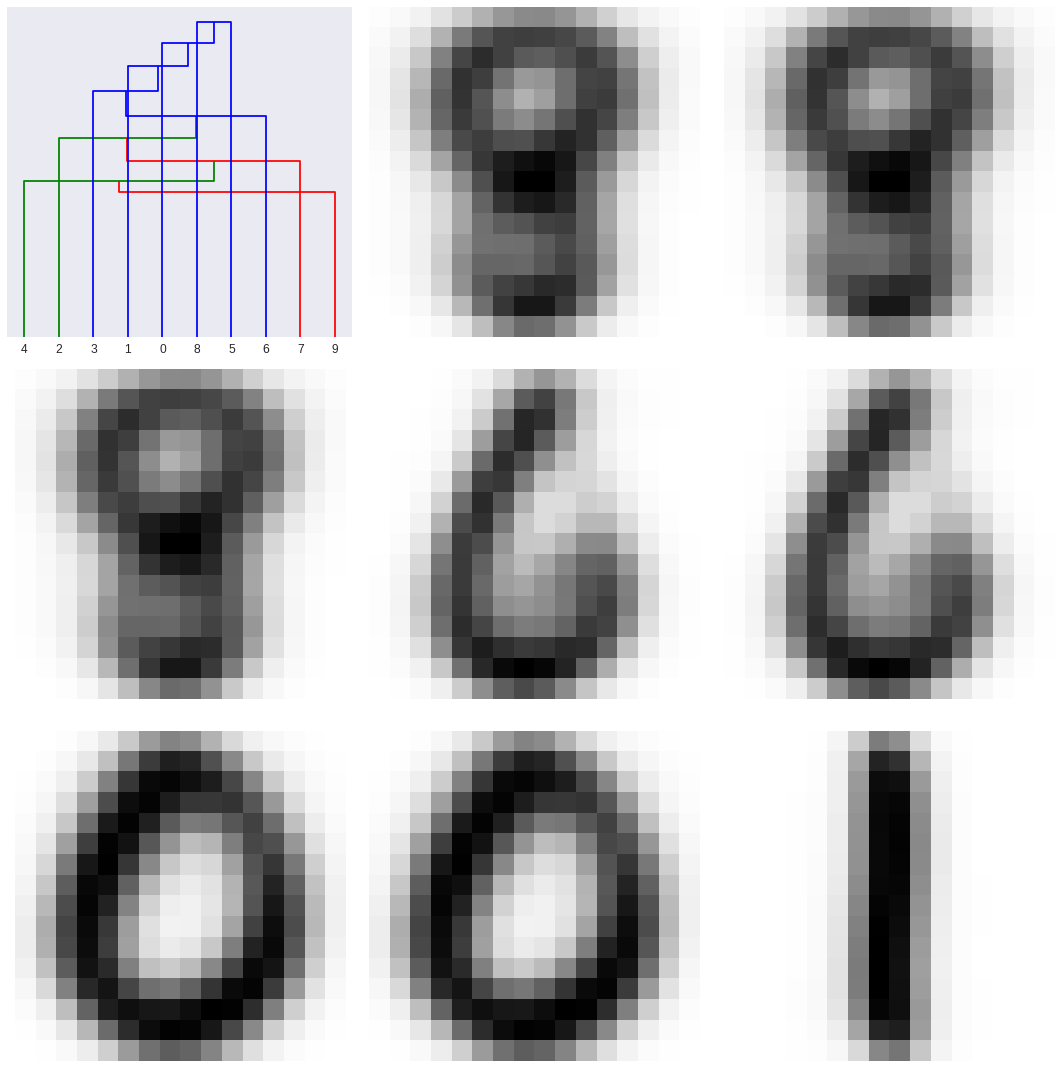

In [81]:
with warnings.catch_warnings():
    warnings.simplefilter('error')
    usps = loadmat('./usps.mat')
    X = usps['data_patterns'].T
    plt.figure()
    _, axes = plt.subplots(3, 3, figsize=(15, 15))
    k = 10
    axes = axes.flatten()
    km_mu, r, _ = kmeans(X, k, print_progress=False)
    _, kmloss, mergeidx = kmeans_agglo(X, r)
    gmm_pi, gmm_mu, gmm_sigma, _ = em_gmm(X, k, init_kmeans=None,
                                          print_progress=True, tol=1e-1)
    ax1 = axes[0]
    ax1.grid()
    ax1.set_yticks([])
    agglo_dendro(kmloss, mergeidx, ax=ax1)
    for ax, (_, c2) in zip(axes[1:], mergeidx[1:]):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(km_mu[c2].reshape(16, 16),
                   interpolation='none', aspect='equal')
    plt.tight_layout()

In [95]:
from sklearn.manifold import TSNE

model = TSNE()
data = np.vstack((X, km_mu, gmm_mu))
proj = model.fit_transform(data)

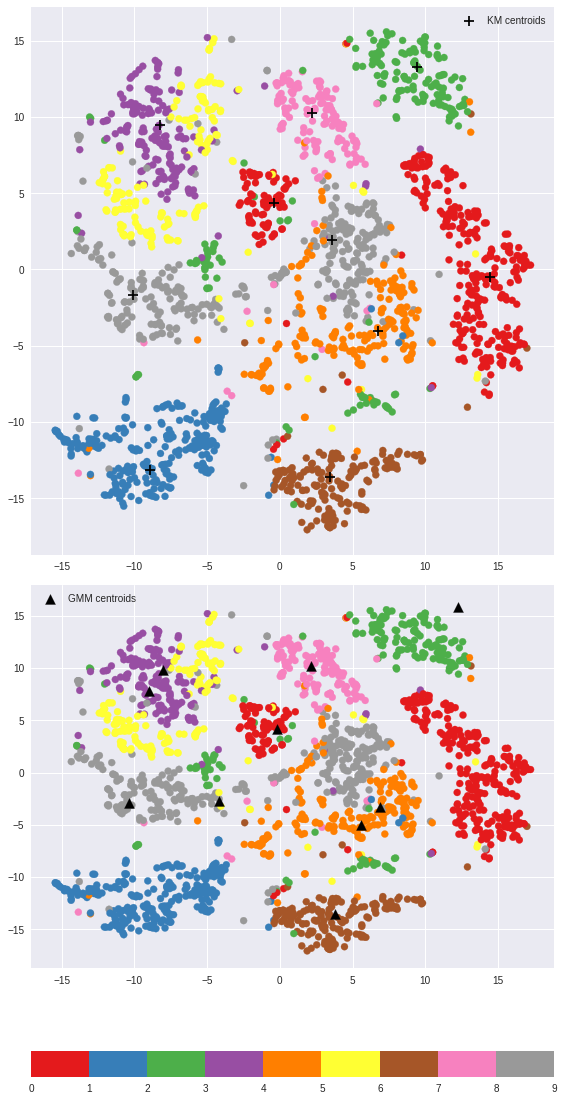

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))
axes = axes.flatten()
ax1 = axes[0]
ax2 = axes[1]
labels = np.argwhere(usps['data_labels'].T == 1)[:, 1]
ax1.scatter(*proj[:-20].T, c=labels, cmap=plt.cm.Set1)
ax1.scatter(*proj[-20:-10].T, c='k', marker='+', s=100, label='KM centroids')
ax1.legend()

cax = ax2.scatter(*proj[:-20].T, c=labels, cmap=plt.cm.Set1)
ax2.scatter(*proj[-10:].T, c='k', marker='^', s=100, label='GMM centroids')
ax2.legend()
ticks = sorted(np.unique(labels))
cbar = fig.colorbar(cax, ticks=ticks, orientation='horizontal')
cbar.ax.set_yticklabels(ticks)
plt.tight_layout()

In [85]:
from sklearn.metrics import classification_report

Y = usps['data_labels'].T

y_pred = np.zeros_like(labels)
for i in range(10):
    matching_label = Y[r == i].sum(axis=0).argmax()
    y_pred[r == i] = matching_label

print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.81      0.84       359
          1       0.92      0.97      0.95       264
          2       0.93      0.64      0.76       198
          3       0.49      0.74      0.59       166
          4       0.64      0.57      0.60       200
          5       0.00      0.00      0.00       160
          6       0.61      0.81      0.70       170
          7       0.78      0.76      0.77       147
          8       0.54      0.55      0.55       166
          9       0.39      0.63      0.48       177

avg / total       0.66      0.68      0.66      2007



/home/mtambos/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
def km_cluster_idx(usps: Dict[str, np.ndarray], r: np.ndarray) -> np.ndarray:
    # noinspection PyTypeChecker
    labels = np.argwhere(usps['data_labels'].T == 1)[:, 1]
    Y = usps['data_labels'].T
    y_pred = np.zeros_like(labels)
    for i in range(10):
        matching_label = Y[r == i].sum(axis=0).argmax()
        y_pred[r == i] = matching_label
    return y_pred


def gmm_cluster_idx(usps: Dict[str, np.ndarray], pi, mu, sigma, tol=1e-5):
    X = usps['data_patterns'].T
    N, _ = X.shape
    k, _ = mu.shape
    likelihood = np.zeros((N, k))

    for centr in range(k):
        likelihood[:, centr] = pi[centr] * norm_pdf(X, mu[centr], sigma[centr], tol=tol)**2
    r = likelihood.argmax(axis=-1)
    
    return km_cluster_idx(usps, r)

In [100]:
from sklearn.metrics import classification_report

Y = usps['data_labels'].T

y_pred = gmm_cluster_idx(usps, gmm_pi, gmm_mu, gmm_sigma)

print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.63      0.97      0.76       359
          1       0.41      0.99      0.58       264
          2       0.96      0.67      0.79       198
          3       0.66      0.49      0.57       166
          4       0.69      0.72      0.71       200
          5       0.58      0.50      0.54       160
          6       0.00      0.00      0.00       170
          7       0.72      0.75      0.74       147
          8       0.61      0.19      0.29       166
          9       0.00      0.00      0.00       177

avg / total       0.53      0.59      0.53      2007



/home/mtambos/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Assignment 10

In [139]:
def gammaidx(X, k):
    dists = squareform(pdist(X))
    dists = np.partition(dists, kth=k, axis=1)[:, :k+1]
    dists = np.sort(dists, axis=1)[:, 1:]
    y = dists.mean(axis=1)
    return y


def auc(y_true, y_val, plot=False, fname: str=None):
    sorted_idx = np.argsort(y_val)[::-1]
    y_val = y_val[sorted_idx]
    y_true: np.ndarray = y_true[sorted_idx] == 1
    thresholds = np.copy(y_val)
    br_thresholds = np.broadcast_to(thresholds, (len(y_val), len(y_val))).T
    y_pred = y_val >= br_thresholds
    tp = (y_pred & y_true).sum(axis=1)
    fp = (y_pred & ~y_true).sum(axis=1)

    tpr: np.ndarray = tp / len(y_true[y_true])
    fpr: np.ndarray = fp / len(y_true[~y_true])
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.scatter(fpr, tpr, s=100, c='r')
        plt.plot(*np.r_['0,2', 0:1.1:.1, 0:1.1:.1], '--', alpha=0.7)
        plt.ylim(0, 1)
        plt.ylabel("True positive rate")
        plt.xlim(0, 1)
        plt.xlabel("False positive rate")
        if fname is None:
            fname = 'auc.png'
        plt.savefig(fname)
        plt.show()

    c = np.trapz(tpr, fpr)
    return c


In [102]:
lab_data = np.load('./lab_data.npz')

In [129]:
km_mu, *_ = kmeans(lab_data['X'], 3, print_progress=False)
_, gmm_mu, gmm_sigma, _ = em_gmm(lab_data['X'], 3, init_kmeans=km_mu,
                                 print_progress=False, tol=1e-1)
sorted(gmm_mu, key=lambda x: x[0])

Number of iterations: 16. Loss: 80.2972338120108
Number of iterations: 25. Log likelihood: 10.539009701127208


[array([-0.07117879,  0.06915395, -1.01893152]),
 array([ 0.11408639,  0.14507352, -0.15056507]),
 array([ 0.50019964,  0.04448412,  1.0177551 ])]

Own max AUC score: 0.8765999999999999; k: 6
SKLearn max AUC score: 0.8765999999999999; k: 6


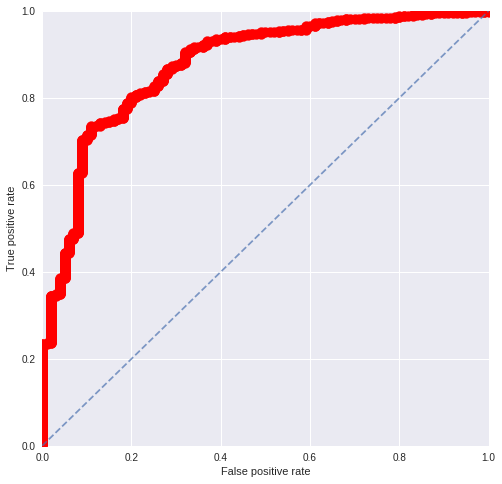

0.87659999999999993

In [137]:
from sklearn.metrics import roc_auc_score

scores = np.zeros(len(lab_data['X']) - 1)
sk_scores = np.zeros(len(lab_data['X']) - 1)
for k in range(1, len(lab_data['X'])):
    y_pred = -gammaidx(lab_data['X'], k)
    scores[k - 1] = auc(lab_data['Y'], y_pred)
    sk_scores[k - 1] = roc_auc_score(lab_data['Y'], y_pred)

k = scores.argmax() + 1
print(f"Own max AUC score: {scores.max()}; k: {k}")
print(f"SKLearn max AUC score: {sk_scores.max()}; k: {sk_scores.argmax() + 1}")
y_pred = -gammaidx(lab_data['X'], k)
auc(lab_data['Y'], y_pred, True)

In [131]:
def out_score(X, pi, mu, sigma, tol=1e-5):
    N, _ = X.shape
    k, _ = mu.shape
    gamma = np.zeros((k, N))
    likelihood = np.zeros(N)

    for centr in range(k):
        g = norm_pdf(X, mu[centr], sigma[centr], tol=tol)
        gamma[centr] = pi[centr] * g
        likelihood += pi[centr] * g**2
    likelihood /= gamma.sum(axis=0)
    return np.log(likelihood)

Number of iterations: 13. Loss: 80.2972338120108
Number of iterations: 25. Log likelihood: 10.539009701127208


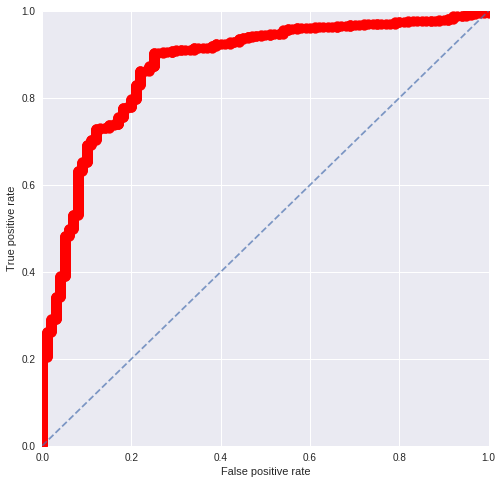

k: 2. AUC: 0.8744777777777777


In [143]:
km_mu, *_ = kmeans(lab_data['X'], 3, print_progress=False)
gmm_pi, gmm_mu, gmm_sigma, _ = em_gmm(lab_data['X'], 3, init_kmeans=km_mu,
                                 print_progress=False, tol=1e-1)
y_pred = out_score(lab_data['X'], gmm_pi, gmm_mu, gmm_sigma)
auc_score = auc(lab_data['Y'], y_pred, True, fname='assignment10_4.png')
print(f"k: {2}. AUC: {auc_score}")

In [2]:
from mpl_toolkits.mplot3d import Axes3D

lab_data = np.load('./lab_data.npz')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*lab_data['X'][lab_data['Y'] == 1].T, label='Inliers')
ax.scatter(*lab_data['X'][lab_data['Y'] == -1].T, label='Outliers')
ax.legend()
plt.show()


Number of iterations: 26. Loss: 80.29723381201079
Number of iterations: 25. Log likelihood: 10.539009701127208
[[ 0.50019964  0.04448412  1.0177551 ]
 [-0.07117879  0.06915395 -1.01893152]
 [ 0.11408639  0.14507352 -0.15056507]]


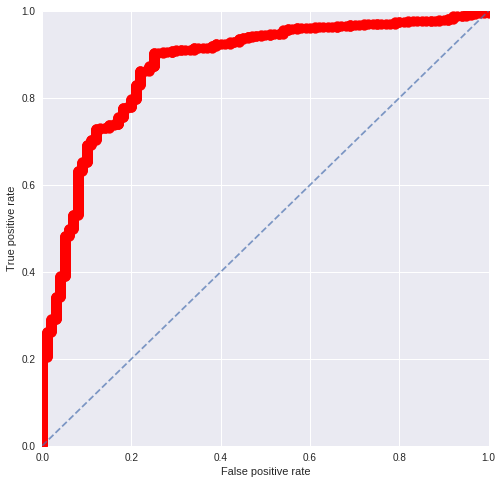

k: 3. AUC: 0.8744777777777777


In [147]:
lab_data = np.load('./lab_data.npz')
km_mu, *_ = kmeans(lab_data['X'], 3, print_progress=False)
gmm_pi, gmm_mu, gmm_sigma, _ = em_gmm(lab_data['X'], 3, init_kmeans=km_mu,
                                      print_progress=False, tol=1e-1)
print(gmm_mu)

y_pred = out_score(lab_data['X'], gmm_pi, gmm_mu, gmm_sigma)
auc_score = auc(lab_data['Y'], y_pred, True, fname='assignment10_4.png')
print(f"k: {3}. AUC: {auc_score}")
